# Plots for Needle in Haystack Tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

import logging
import pickle
from datetime import datetime
import os
from data_processing import gen_ckpt_steps

#### Experiment Details

In [13]:
valA = "gaussA"
valC = "_gauss_C"
state_dim = 10
ckpt_step = 141000
experiment = "250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
datasource = "val"
nope = False

model_dir = "../outputs/GPT2" + ("_NoPE" if nope else "") + "/"

errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={ckpt_step}.ckpt"
errs_loc = errs_dir + f"/needle_{datasource}_" + f"{valA}_state_dim_{state_dim}_"
seg_ext_errs_loc = errs_dir + f"/needle_{datasource}_fin_seg_ext_" + f"{valA}_state_dim_{state_dim}_"


quartiles_file = model_dir + experiment + "/needles/quartiles.npz"

seg_ext_quartiles_file = model_dir + experiment + "/needles/seg_ext_quartiles.npz"

if os.path.exists(quartiles_file):
    print(f"Loading quartiles from {quartiles_file}")
    quartiles = np.load(quartiles_file)

if os.path.exists(seg_ext_quartiles_file):
    print(f"Loading seg ext quartiles from {seg_ext_quartiles_file}")
    seg_ext_quartiles = np.load(seg_ext_quartiles_file)


print(f"Loading errors from {errs_loc}")

Loading errors from ../outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=141000.ckpt/needle_val_gaussA_state_dim_10_


#### load the err_lss_examples at path which is numpy array

In [15]:
with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
    err_lss_examples = pickle.load(f)

with open(seg_ext_errs_loc + "err_lss_examples.pkl", "rb") as f:
    seg_ext_err_lss_examples = pickle.load(f)

In [16]:
for key in err_lss_examples.keys():
    print(f"shape of examples[{key}]: {err_lss_examples[key].shape}")

for key in seg_ext_err_lss_examples.keys():
    print(f"shape of seg_ext_examples[{key}]: {seg_ext_err_lss_examples[key].shape}")

shape of examples[MOP]: (200, 19, 2000, 251)
shape of examples[Zero]: (200, 19, 2000, 251)
shape of examples[Kalman_rem]: (200, 19, 2000, 251)
shape of examples[Analytical_Kalman]: (200, 19, 251)
shape of examples[Analytical_Simulation]: (200, 19, 2000, 251)
shape of examples[OLS_ir_1]: (200, 19, 2000, 251)
shape of examples[OLS_analytical_ir_1]: (200, 19, 2000, 251)
shape of examples[OLS_ir_2]: (200, 19, 2000, 251)
shape of examples[OLS_analytical_ir_2]: (200, 19, 2000, 251)
shape of examples[OLS_ir_3]: (200, 19, 2000, 251)
shape of examples[OLS_analytical_ir_3]: (200, 19, 2000, 251)
shape of seg_ext_examples[MOP]: (200, 1, 2000, 251)
shape of seg_ext_examples[Zero]: (200, 1, 2000, 251)
shape of seg_ext_examples[Kalman_rem]: (200, 1, 2000, 251)
shape of seg_ext_examples[Analytical_Kalman]: (200, 1, 251)
shape of seg_ext_examples[Analytical_Simulation]: (200, 1, 2000, 251)
shape of seg_ext_examples[OLS_ir_1]: (200, 1, 2000, 251)
shape of seg_ext_examples[OLS_analytical_ir_1]: (200, 1, 

#### Compute the Quartiles

In [17]:
def comp_quartiles(err_lss_examples, ratio=False):
    quartiles = {}
    kal_err = None
    if ratio:
        kal_err = err_lss_examples["Kalman_rem"]
    

    for key in err_lss_examples.keys():
        if not (key == "Analytical_Kalman" or key == "Kalman_rem" or key == "Kalman"):
            if ratio:
                rat = err_lss_examples[key] / kal_err
            else:
                rat = err_lss_examples[key]
            med = np.median(rat, axis=2)
            print(f"shape of med: {med.shape}")
            quartiles[key] = np.percentile(med, [25,50,75], axis=0)
            print(f"shape of quartiles[{key}]: {quartiles[key].shape}")
            
    return quartiles


In [18]:
if valA == "gaussA":
    rat = True
else:
    rat = False
quartiles = comp_quartiles(err_lss_examples, ratio=rat)

#save quartiles to npz file
os.makedirs(os.path.dirname(quartiles_file), exist_ok=True)
np.savez(quartiles_file, **quartiles)

/tmp/ipykernel_770068/341765924.py:11: RuntimeWarning: invalid value encountered in divide
  rat = err_lss_examples[key] / kal_err


shape of med: (200, 19, 251)
shape of quartiles[MOP]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[Zero]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[Analytical_Simulation]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_ir_1]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_analytical_ir_1]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_ir_2]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_analytical_ir_2]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_ir_3]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_analytical_ir_3]: (3, 19, 251)


In [19]:
seg_ext_quartiles = comp_quartiles(seg_ext_err_lss_examples, ratio=rat)

#save seg_ext_quartiles to npz file
os.makedirs(os.path.dirname(seg_ext_quartiles_file), exist_ok=True)
np.savez(seg_ext_quartiles_file, **seg_ext_quartiles)

/tmp/ipykernel_770068/341765924.py:11: RuntimeWarning: invalid value encountered in divide
  rat = err_lss_examples[key] / kal_err


shape of med: (200, 1, 251)
shape of quartiles[MOP]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[Zero]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[Analytical_Simulation]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_ir_1]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_analytical_ir_1]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_ir_2]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_analytical_ir_2]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_ir_3]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_analytical_ir_3]: (3, 1, 251)


## Plotting Code

### final trace

In [20]:
haystack_len = quartiles["MOP"].shape[1]

print(f"quartiles[mop] shape: {quartiles['MOP'].shape}, seg_ext_quartiles[mop] shape: {seg_ext_quartiles['MOP'].shape}")

print(f"haystack_len: {haystack_len}")

quartiles[mop] shape: (3, 19, 251), seg_ext_quartiles[mop] shape: (3, 1, 251)
haystack_len: 19


real_steps: [230, 231, 232, 234, 239], real_steps_ext: [228, 229, 230, 232, 237]
key_count: 0
needle: 0, step: 1, real_step: 230
y: 1.7025214032302114
needle: 0, step: 2, real_step: 231
y: 1.9053346265414755
needle: 0, step: 3, real_step: 232
y: 1.7530860983924192
needle: 0, step: 5, real_step: 234
y: 1.6570395182198405
needle: 0, step: 10, real_step: 239
y: 1.504156483207741
key_count: 1
needle: 0, step: 1, real_step: 230
y: 2.5683659998943824
needle: 0, step: 2, real_step: 231
y: 2.5726403005280605
needle: 0, step: 3, real_step: 232
y: 2.6035100797817865
needle: 0, step: 5, real_step: 234
y: 2.5212336145151824
needle: 0, step: 10, real_step: 239
y: 2.567371872052572
key_count: 2
key_count: 2
needle: 0, step: 1, real_step: 230
y: 1.7310830192283997
needle: 0, step: 2, real_step: 231
y: 1.7186009738768444
needle: 0, step: 3, real_step: 232
y: 1.6826600354380514
needle: 0, step: 5, real_step: 234
y: 1.6191564448662028
needle: 0, step: 10, real_step: 239
y: 1.5172508563916294
key_count: 

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

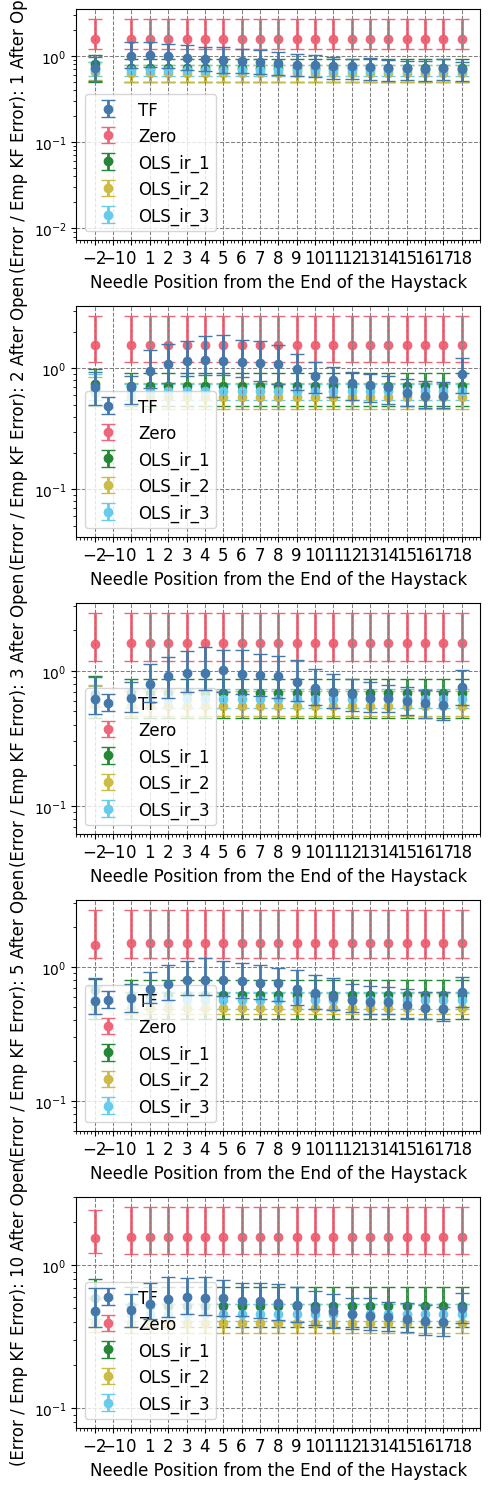

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

In [21]:
steps_in = [1,2,3,5,10]
open_paren_ind = 229
real_steps = [x + open_paren_ind for x in steps_in]
real_steps_ext = [x + open_paren_ind-2 for x in steps_in]

fig, ax = plt.subplots(len(steps_in), 1, sharex=True, figsize=(5, 3*len(steps_in)))

#get a high contrast color map
colors = ["#4477AA", "#EE6677", "#228833", "#CCBB44", "#66CCEE"]

print(f"real_steps: {real_steps}, real_steps_ext: {real_steps_ext}")


for needle in range(haystack_len):
    key_count = 0
    for key in quartiles.keys():
        print(f"key_count: {key_count}")
        if "OLS_analytical" not in key and "Simulation" not in key:
            # ax[needle].scatter(quartiles[key][1, needle], label=key)
            step_count = 0
            for step in steps_in:

                key_label = "TF" if key == "MOP" else key

                print(f"needle: {needle}, step: {step}, real_step: {real_steps[step_count]}")

                y = quartiles[key][1, needle, real_steps[step_count]]
                print(f"y: {y}")
                if valA == "gaussA":
                    y -= 1
                yerr = [
                    quartiles[key][1, needle, real_steps[step_count]] - quartiles[key][0, needle, real_steps[step_count]],
                    quartiles[key][2, needle, real_steps[step_count]] - quartiles[key][1, needle, real_steps[step_count]]
                ]#

                yerr = np.array([[yerr[0]], [yerr[1]]])

                ax[step_count].errorbar(
                    haystack_len - needle - 1,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label=f"{key_label}" if needle == 0 else "_nolegend_",
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color=colors[key_count],
                    linewidth=2
                )

                step_count += 1
            key_count += 1

key_count = 0
for key in seg_ext_quartiles.keys():
    if "OLS_analytical" not in key and "Simulation" not in key:
        step_count = 0
        for step in steps_in:
            y = seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]]
            if valA == "gaussA":
                y -= 1
            yerr = [
                seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]] - seg_ext_quartiles[key][0, 0, real_steps_ext[step_count]],
                seg_ext_quartiles[key][2, 0, real_steps_ext[step_count]] - seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]]
            ]

            yerr = np.array([[yerr[0]], [yerr[1]]])
            
            ax[step_count].errorbar(
                -2,
                y,
                yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                fmt='o',
                label="_nolegend_",
                capsize=5,
                zorder=haystack_len if key == "MOP" else 0, color = colors[key_count], 
                linewidth=2
            )

            ax[step_count].legend(fontsize = 12)
            ax[step_count].set_xlabel("Needle Position from the End of the Haystack", fontsize=12, fontname="Times New Roman")
            ax[step_count].set_ylabel(("(" if valA== "gaussA" else "") + "Error" + (" / Emp KF Error)" if valA == "gaussA" else "") + f": {step} After Open", fontsize=12)
            ax[step_count].set_xlim(-3, haystack_len)
            ax[step_count].grid(True)
            ax[step_count].minorticks_on()
            ax[step_count].grid(which='major', linestyle='--', linewidth='0.75', color='gray')
            # ax[step_count].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
            #set the grid to be on integer values for x-axis
            ax[step_count].set_xticks(np.arange(-2, haystack_len, 1))
            ax[step_count].set_yscale('log')
            # ax[step_count].set_ylim(0.3, 3)
            ax[step_count].tick_params(axis='x', which='both', labelbottom=True, labelsize=12)

            step_count += 1
        key_count += 1


fig.tight_layout()

plt.show()

os.makedirs(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}", exist_ok=True)
fig.savefig(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}/error_ratios_{valA}_state_dim_{state_dim}{valC}_step_{ckpt_step}.pdf", transparent=True)



haystack_len: 19


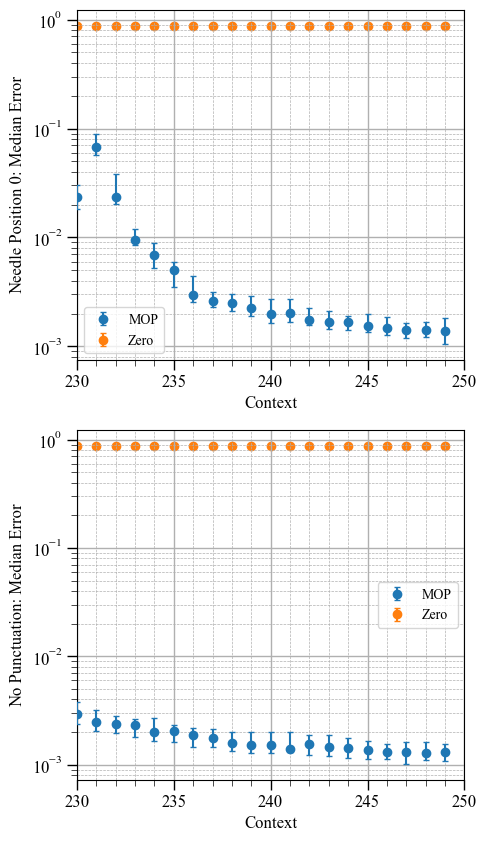

In [5]:
#make a figure with haystack_len subplots
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 5*2))
# fig, ax = plt.subplots(haystack_len, 1, sharex=True, figsize=(5, 5*haystack_len))

print(f"haystack_len: {haystack_len}")
ax_count = 0
for needle in range(haystack_len):
    if needle == haystack_len - 1:
        for key in quartiles.keys():
            if "OLS_analytical" not in key:
                # ax[ax_count].scatter(quartiles[key][1, needle], label=key)
                ax[ax_count].errorbar(np.arange(quartiles[key].shape[-1]), quartiles[key][1, needle], yerr=[quartiles[key][1, needle] - quartiles[key][0, needle], quartiles[key][2, needle] - quartiles[key][1, needle],], fmt='o', label=f"{key}", capsize=2, zorder=haystack_len if key == "MOP" else 0)
        ax[ax_count].legend()
        ax[ax_count].grid(which="both")
        ax[ax_count].set_xlim(left=230, right=quartiles[key].shape[-1])  # set the x axis limits haystack_len*12 + 2
        # ax[ax_count].set_ylim(bottom=0, top=5.5)  # set the y axis limits

        # Optionally, customize major and minor ticks
        ax[ax_count].minorticks_on()

        # Set minor vertical grid lines to be on intervals of 1
        # Set major ticks on every interval of 50
        ax[ax_count].set_xticks(range(int(ax[ax_count].get_xlim()[0]), int(ax[ax_count].get_xlim()[1]) + 1, 5))

        # Set minor vertical grid lines to be on intervals of 1
        ax[ax_count].set_xticks(range(int(ax[ax_count].get_xlim()[0]), int(ax[ax_count].get_xlim()[1]) + 1, 1), minor=True)

        ax[ax_count].tick_params(axis='both', which='major', length=7, width=1, labelsize=12)
        ax[ax_count].tick_params(axis='both', which='minor', length=4, width=0.5, labelsize=0)
        ax[ax_count].tick_params(axis='x', which='both', labelbottom=True, labelsize=12)
        ax[ax_count].grid(which='major', linestyle='-', linewidth=1)
        ax[ax_count].grid(which='minor', linestyle='--', linewidth=0.5)
        ax[ax_count].set_ylabel(f"Needle Position {haystack_len - needle - 1}: Median Error", fontsize=12)
        ax[ax_count].set_xlabel("Context", fontsize=12)
        ax[ax_count].set_yscale('log')
        # ax[ax_count].set_title(f"Prediction Error for Needle Position {needle}", fontsize=30)
        ax_count += 1


needle = 0
for key in seg_ext_quartiles.keys():
    if "OLS_analytical" not in key:
        x_values = np.arange(seg_ext_quartiles[key].shape[-1] - 1)
        y_values = seg_ext_quartiles[key][1, needle][:-1]
        yerr_lower = seg_ext_quartiles[key][1, needle][:-1] - seg_ext_quartiles[key][0, needle][:-1]
        yerr_upper = seg_ext_quartiles[key][2, needle][:-1] - seg_ext_quartiles[key][1, needle][:-1]
        
        ax[ax_count].errorbar(x_values, y_values, yerr=[yerr_lower, yerr_upper], fmt='o', label=f"{key}", capsize=2, zorder=haystack_len if key == "MOP" else 0)
        
ax[ax_count].legend()
ax[ax_count].grid(which="both")
ax[ax_count].set_xlim(left=230, right=seg_ext_quartiles[key].shape[-1] - 1)  # set the x axis limits haystack_len*12 + 2
# ax[ax_count].set_ylim(bottom=0, top=5.5)  # set the y axis limits

# Optionally, customize major and minor ticks
ax[ax_count].minorticks_on()

# Set minor vertical grid lines to be on intervals of 1
# Set major ticks on every interval of 50
ax[ax_count].set_xticks(range(int(ax[ax_count].get_xlim()[0]), int(ax[ax_count].get_xlim()[1]) + 1, 5))

# Set minor vertical grid lines to be on intervals of 1
ax[ax_count].set_xticks(range(int(ax[ax_count].get_xlim()[0]), int(ax[ax_count].get_xlim()[1]) + 1, 1), minor=True)

ax[ax_count].tick_params(axis='both', which='major', length=7, width=1, labelsize=12)
ax[ax_count].tick_params(axis='both', which='minor', length=4, width=0.5, labelsize=0)
ax[ax_count].tick_params(axis='x', which='both', labelbottom=True, labelsize=12)
ax[ax_count].grid(which='major', linestyle='-', linewidth=1)
ax[ax_count].grid(which='minor', linestyle='--', linewidth=0.5)
ax[ax_count].set_ylabel(f"No Punctuation: Median Error", fontsize=12)
ax[ax_count].set_xlabel("Context", fontsize=12)
ax[ax_count].set_yscale('log')
# ax[ax_count].set_title(f"Prediction Error for Needle Position {needle}", fontsize=30)

#add the date and time to the filename
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

# #add a caption to the bottom of the figure
# fig.text(0.5, 0.1, f"Median of {num_examples} haystack configuration examples. step=" + str(ckpt_step) + "_" + timestamp, ha='center', fontsize=30)

# Needle in a Haystack: Training Convergence

In [ ]:
minval = 3000
maxval = 105000
interval = 3000
ckpt_steps = gen_ckpt_steps(minval, maxval, interval)

if valA == "gaussA":
    rat = True
else:
    rat = False

In [ ]:
model_dir = "../outputs/GPT2" + ("_NoPE" if nope else "") + "/"

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5, 5)

quartiles_ckpt = []
pred_ckpts = []
for ckpt_step in ckpt_steps:

    errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={ckpt_step}.ckpt"
    errs_loc = errs_dir + f"/needle_{datasource}_" + f"{valA}_state_dim_{state_dim}_" #for the next ones add train_conv to the file name
    seg_ext_errs_loc = errs_dir + f"/needle_{datasource}_fin_seg_ext_" + f"{valA}_state_dim_{state_dim}_"

    if os.path.exists(errs_loc + "err_lss_examples.pkl"):
        with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
            err_lss_examples = pickle.load(f)

        if os.path.exists(seg_ext_errs_loc + "err_lss_examples.pkl"):
            with open(seg_ext_errs_loc + "err_lss_examples.pkl", "rb") as f:
                seg_ext_err_lss_examples = pickle.load(f)

        pred_ckpts.append(ckpt_step)

        quartiles = comp_quartiles(err_lss_examples, ratio=rat)

        for key in quartiles.keys():
            ax.plot(np.arange(quartiles[key].shape[-1]), quartiles[key][1, 0], label=f"{key}")

        # seg_ext_quartiles = comp_quartiles(seg_ext_err_lss_examples, ratio=rat)



